# 📘 MobileNetV3 - FER2013 - Train and Evaluation and Low Light Image

Notebook này trình bày cách huấn luyện và đánh giá mô hình **MobileNetV3** trên tập dữ liệu cảm xúc khuôn mặt **FER2013**.

Nội dung gồm:
1.	Tải và tiền xử lý dữ liệu
2.	Định nghĩa mô hình (MobileNetV3)
3.	Huấn luyện mô hình
4.	Đánh giá: Độ chính xác (Accuracy), Ma trận nhầm lẫn (Confusion Matrix), Thời gian suy luận (Inference Time), Kích thước mô hình (Model Size)

Cấu trúc thư mục dữ liệu phải được tổ chức thành hai thư mục train/ và test/, mỗi thư mục chứa các thư mục con tương ứng với từng nhãn cảm xúc.

In [111]:
# 📚 Import thư viện
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess_input

In [114]:
IMG_SIZE = 224
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess_input,
    validation_split=0.2,
    brightness_range=[0.1, 0.1]  # Giảm độ sáng (tối hơn)
)

test_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess_input,
    brightness_range=[0.1, 0.1]  # Cũng áp dụng giảm độ sáng cho test
)

train_generator = train_datagen.flow_from_directory(
    '../../../Bai_4/data/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '../../../Bai_4/data/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    '../../../Bai_4/data/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Ảnh minh hoạ trước và sau khi giảm độ sáng:

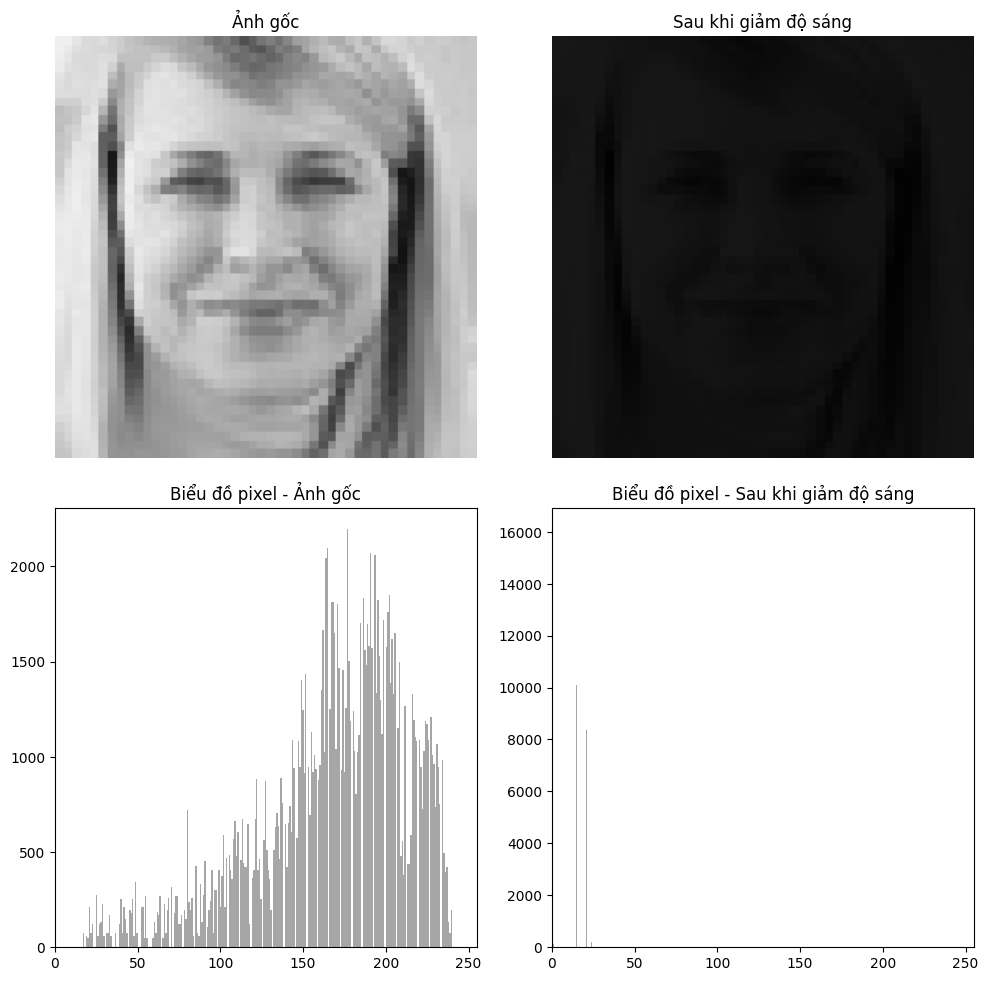

In [125]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

IMG_SIZE = 224
sample_dir = '../../../Bai_4/data/train'  # đổi nếu Loc test thư mục khác
class_name = 'happy'  # ví dụ: 'healthy', 'diseased',...

# Tải 1 ảnh mẫu (chưa augmentation)
img_path = f"{sample_dir}/{class_name}/Training_96512550.jpg"
img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = img_to_array(img)  # Chuyển thành mảng NumPy
img_array = np.expand_dims(img_array, axis=0)

# Tạo datagen giảm độ sáng
datagen = ImageDataGenerator(brightness_range=[0.1, 0.1])
aug_iter = datagen.flow(img_array)

# Hiển thị ảnh gốc và ảnh đã giảm sáng
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Ảnh gốc
ax[0, 0].imshow(img_array[0].astype('uint8'))
ax[0, 0].set_title("Ảnh gốc")
ax[0, 0].axis('off')  # Tắt trục

# Biểu đồ pixel của ảnh gốc
ax[1, 0].hist(img_array[0].ravel(), bins=256, color='gray', alpha=0.7)
ax[1, 0].set_title("Biểu đồ pixel - Ảnh gốc")
ax[1, 0].set_xlim([0, 255])

# Hiển thị ảnh sau khi giảm sáng
aug_img = next(aug_iter)[0].astype('uint8')
ax[0, 1].imshow(aug_img)
ax[0, 1].set_title("Sau khi giảm độ sáng")
ax[0, 1].axis('off')  # Tắt trục

# Biểu đồ pixel của ảnh đã giảm sáng
ax[1, 1].hist(aug_img.ravel(), bins=256, color='gray', alpha=0.7)
ax[1, 1].set_title("Biểu đồ pixel - Sau khi giảm độ sáng")
ax[1, 1].set_xlim([0, 255])

plt.tight_layout()  # Căn chỉnh các subplots
plt.show()

In [126]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV3Small

# Base model
base_model = MobileNetV3Small(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Functional API
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(7, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [127]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


718/718 ━━━━━━━━━━━━━━━━━━━━ 173s 233ms/step - accuracy: 0.4013 - loss: 1.5522 - val_accuracy: 0.4917 - val_loss: 1.3338
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 168s 234ms/step - accuracy: 0.5578 - loss: 1.2004 - val_accuracy: 0.5414 - val_loss: 1.2261
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 166s 232ms/step - accuracy: 0.6046 - loss: 1.0698 - val_accuracy: 0.5705 - val_loss: 1.1907
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 185s 258ms/step - accuracy: 0.6411 - loss: 0.9864 - val_accuracy: 0.5799 - val_loss: 1.1411
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 193s 268ms/step - accuracy: 0.6751 - loss: 0.8879 - val_accuracy: 0.5917 - val_loss: 1.1183
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 196s 273ms/step - accuracy: 0.7170 - loss: 0.7728 - val_accuracy: 0.5992 - val_loss: 1.1776
Epoch 7/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 184s 256ms/step - accuracy: 0.7512 - loss: 0.6926 - val_accuracy: 0.5818 - val_loss: 1.3058
Epoch 8/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 172s 239ms/step - accuracy: 0.7822 - loss: 0.61

7178/7178 ━━━━━━━━━━━━━━━━━━━━ 69s 10ms/step - accuracy: 0.5402 - loss: 1.2714
Test Accuracy: 59.85%
7178/7178 ━━━━━━━━━━━━━━━━━━━━ 69s 9ms/step


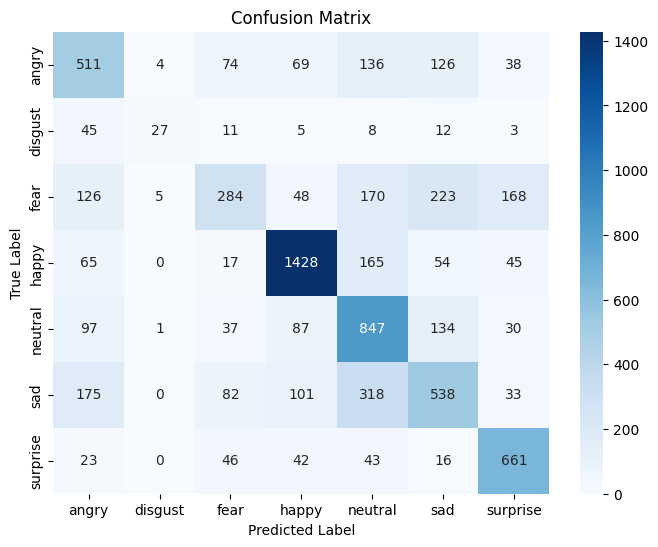

In [128]:
# Accuracy
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Confusion Matrix
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [129]:
# Inference Time
import time
start = time.time()
_ = model.predict(test_generator)
end = time.time()

inference_time = (end - start) / len(test_generator.filenames) * 1000  # ms per image
print(f"Average Inference Time: {inference_time:.2f} ms/image")

7178/7178 ━━━━━━━━━━━━━━━━━━━━ 66s 9ms/step
Average Inference Time: 9.37 ms/image


In [130]:
model.save("mobilenetv3_fer2013_low_light_V1.keras")  # lưu đúng định dạng mới
size_mb = os.path.getsize("mobilenetv3_fer2013_low_light_V1.keras") / (1024 * 1024)
print(f"Model Size: {size_mb:.2f} MB")

Model Size: 9.59 MB


In [131]:
from sklearn.metrics import f1_score

# F1-Score macro (trung bình đều các lớp)
f1_macro = f1_score(y_true, y_pred_classes, average='macro')

# F1-Score micro (toàn bộ TP, FP, FN gộp lại)
f1_micro = f1_score(y_true, y_pred_classes, average='micro')

# F1-Score weighted (có tính đến số lượng mẫu từng lớp)
f1_weighted = f1_score(y_true, y_pred_classes, average='weighted')

print(f"F1-Score (Macro): {f1_macro * 100:.2f}%")
print(f"F1-Score (Micro): {f1_micro * 100:.2f}%")
print(f"F1-Score (Weighted): {f1_weighted * 100:.2f}%")

F1-Score (Macro): 54.41%
F1-Score (Micro): 59.85%
F1-Score (Weighted): 58.77%
